In [ ]:
import os
import tensorflow           as tf
import matplotlib.pyplot    as plt
import numpy                as np
from tensorflow.keras       import layers, models

In [3]:
tf.__version__

'2.14.0'

In [3]:
(train_images, train_labels), (val_images, val_labels) = tf.keras.datasets.mnist.load_data()

train_images  = np.expand_dims(train_images, axis=-1)
val_images    = np.expand_dims(val_images, axis=-1)

train_images  = train_images.astype('float32')/255.0
val_images    = val_images.astype('float32')/255.0

train_images  = tf.image.grayscale_to_rgb(tf.image.resize(train_images, (32,32)))
val_images    = tf.image.grayscale_to_rgb(tf.image.resize(val_images, (32,32)))

# take 2000 data points as reserve
test_images   = val_images[8000:]
val_images    = val_images[:8000]

test_labels   = val_labels[8000:]
val_labels    = val_labels[:8000]

train_labels  = tf.keras.utils.to_categorical(train_labels, 10)
val_labels    = tf.keras.utils.to_categorical(val_labels, 10)
test_labels   = tf.keras.utils.to_categorical(test_labels, 10)

batch_size    = 64

def data_generator(images, labels, batch_size = batch_size):
    dataset   = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset   = dataset.cache()
    dataset   = dataset.shuffle(20000)
    dataset   = dataset.batch(batch_size)
    dataset   = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = data_generator(train_images, train_labels)
val_dataset   = data_generator(val_images, val_labels)
test_dataset  = data_generator(test_images, test_labels)

2024-10-17 10:39:07.546419: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
print(f'1. train_labels :{train_labels.shape}, 2. val_labels : {val_labels.shape}, 3. test_labels : {test_labels.shape}')

1. train_labels :(60000, 10), 2. val_labels : (8000, 10), 3. test_labels : (2000, 10)


(64, 32, 32, 3)
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
(64, 10)
Normalized values:  (0.0, 0.99191177)


2024-10-17 10:39:13.251197: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


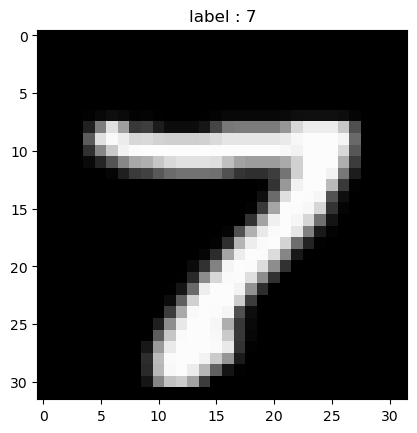

In [5]:
for img_batch, label_batch in train_dataset.take(1):
    print(img_batch.shape)
    print(type(img_batch.shape))
    print(label_batch.shape)
    img = np.array(img_batch)
    label = np.argmax(label_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])
    plt.title(f"label : {label}")

In [5]:
# import shutil

# test_dataset.save("test_dataset")
# shutil.make_archive("test_dataset", "zip", "test_dataset")

'/home/s2310144/workshop/Underspecification/mnist/test_dataset.zip'

In [12]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.backend import epsilon
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Lambda, Dropout
from tensorflow.keras.regularizers import l2

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [7]:
# take a fix initialized weight
tf.random.set_seed(42)
initializer = GlorotUniform(seed=42)

def add_classifier(base_model, num_classes = 10, initializer = initializer):
    x       = base_model.output
    x       = GlobalAveragePooling2D()(x)
    x       = Dropout(0.3)(x)
    x       = layers.Dense(128, 
                           activation = "relu",
                           kernel_initializer = initializer,
                           kernel_regularizer = l2(0.001))(x)
    x       = Dropout(0.3)(x)
    outputs = Dense(num_classes,
                    activation = "softmax",
                    kernel_initializer = initializer, 
                    kernel_regularizer = l2(0.001))(x)

    return outputs

def compile_and_train(model, train_dataset, val_dataset, epochs = 15):
    model.compile(
        optimizer = tf.keras.optimizers.SGD(),
        loss      = 'categorical_crossentropy',
        metrics   = ['accuracy',
                    Precision(name = 'precision'),
                    Recall(name    = 'recall'),
                    AUC(name       = 'auc'),
                    F1Score(name   = 'f1_score')
                    ]
    )

    history = model.fit(train_dataset,
                       epochs          = epochs,
                       validation_data = val_dataset,
                        batch_size     = 256,
                       )
    return history

In [8]:
def plot_performance(model_history, model_name):
    plt.figure(figsize=(10,5))
    
    # plot accuracy 
    plt.subplot(2,3,1)
    plt.plot(model_history.history['accuracy'], label      = 'Training Accurary')
    plt.plot(model_history.history['val_accuracy'], label  = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuarcy')
    plt.legend()
    plt.title(f'{model_name} Accuracy')
    
    #plot loss
    plt.subplot(2,3,2)
    plt.plot(model_history.history['loss'], label          = 'Training Loss')
    plt.plot(model_history.history['val_loss'], label      = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} Loss')
    
    plt.subplot(2,3,3)
    plt.plot(model_history.history['precision'], label     = 'Training Precision')
    plt.plot(model_history.history['val_precision'], label = 'Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(f'{model_name} Precision')

    plt.subplot(2,3,4)
    plt.plot(model_history.history['recall'], label        = 'Training Recall')
    plt.plot(model_history.history['val_recall'], label    = 'Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title(f'{model_name} Recall')
    
    plt.subplot(2,3,5)
    plt.plot(model_history.history['auc'], label          = 'Training AUC')
    plt.plot(model_history.history['val_auc'], label      = 'Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.title(f'{model_name} AUC')
    
    plt.subplot(2,3,6)
    plt.plot(model_history.history['f1_score'], label     = 'Training F1-Score')
    plt.plot(model_history.history['val_f1_score'], label = 'Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.title(f'{model_name} F1-Score')
    
    plt.tight_layout()
    plt.show()

Epoch 1/15
938/938 [==============================] - 9s 8ms/step - loss: 0.6366 - accuracy: 0.8515 - precision: 0.9369 - recall: 0.7794 - auc: 0.9857 - f1_score: 0.8509 - val_loss: 0.2462 - val_accuracy: 0.9731 - val_precision: 0.9814 - val_recall: 0.9621 - val_auc: 0.9994 - val_f1_score: 0.9717
Epoch 2/15
938/938 [==============================] - 8s 8ms/step - loss: 0.3060 - accuracy: 0.9528 - precision: 0.9656 - recall: 0.9398 - auc: 0.9976 - f1_score: 0.9525 - val_loss: 0.2688 - val_accuracy: 0.9621 - val_precision: 0.9716 - val_recall: 0.9538 - val_auc: 0.9977 - val_f1_score: 0.9626
Epoch 3/15
938/938 [==============================] - 7s 8ms/step - loss: 0.2575 - accuracy: 0.9668 - precision: 0.9744 - recall: 0.9586 - auc: 0.9985 - f1_score: 0.9665 - val_loss: 0.1899 - val_accuracy: 0.9839 - val_precision: 0.9879 - val_recall: 0.9810 - val_auc: 0.9998 - val_f1_score: 0.9844
Epoch 4/15
938/938 [==============================] - 7s 8ms/step - loss: 0.2335 - accuracy: 0.9723 - prec

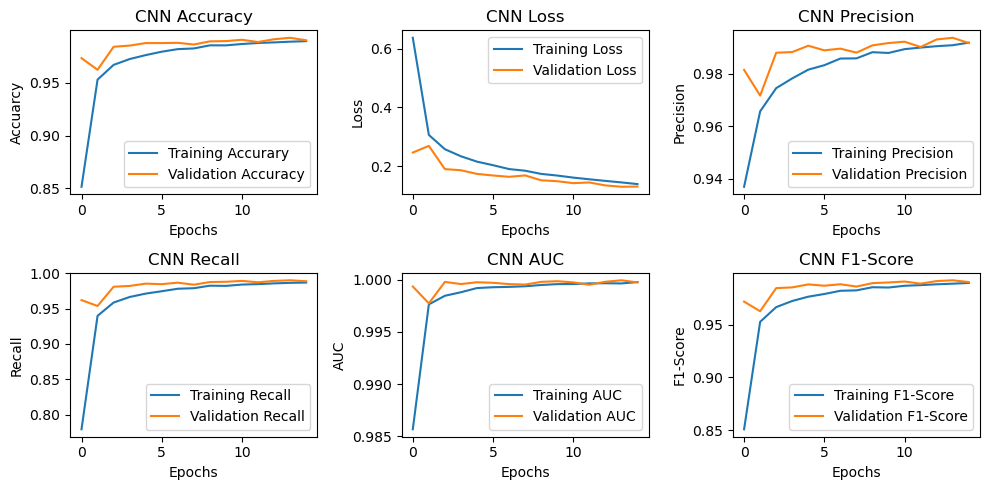

CPU times: user 27min 47s, sys: 2min 23s, total: 30min 10s
Wall time: 1min 54s


In [ ]:
%%time
base_cnn = tf.keras.Sequential([
    tf.keras.Input(shape           = (32, 32, 3)),
    layers.Conv2D(32, kernel_size  = (3,3), activation = "relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size  = (2,2)),
    
    layers.Conv2D(64, kernel_size  = (3,3), activation = "relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size  = (2,2)),

    layers.Conv2D(128, kernel_size = (3,3), activation = "relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size  = (2,2)),
])

cnn_outputs   = add_classifier(base_cnn)

cnn           = tf.keras.Model(inputs  = base_cnn.input,
                               outputs = cnn_outputs,
                               name    = "CNN_MNIST")

cnn_history   = compile_and_train(cnn,
                                train_dataset,
                                val_dataset)

train_acc_cnn = cnn_history.history['accuracy'][-1]
val_acc_cnn   = cnn_history.history['val_accuracy'][-1]
_, test_acc_cnn, _, _, _, _   = cnn.evaluate(test_dataset)

if train_acc_cnn > 0.98 and val_acc_cnn > 0.98 and test_acc_cnn > 0.98:
    cnn.save('models/diff_extrcs/cnn_mnist.h5')
    print('Model saved as cnn_mnist.h5')

plot_performance(cnn_history, "CNN")

In [121]:
cnn.summary()

Model: "CNN_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_36 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_37 (Ba  (None, 13, 13, 64)        25

Epoch 1/15
938/938 [==============================] - 41s 40ms/step - loss: 0.8354 - accuracy: 0.8070 - precision: 0.9266 - recall: 0.7499 - auc: 0.9772 - f1_score: 0.8289 - val_loss: 0.3760 - val_accuracy: 0.9589 - val_precision: 0.9686 - val_recall: 0.9494 - val_auc: 0.9979 - val_f1_score: 0.9589
Epoch 2/15
938/938 [==============================] - 37s 39ms/step - loss: 0.3741 - accuracy: 0.9610 - precision: 0.9702 - recall: 0.9534 - auc: 0.9971 - f1_score: 0.9617 - val_loss: 0.3104 - val_accuracy: 0.9743 - val_precision: 0.9807 - val_recall: 0.9693 - val_auc: 0.9985 - val_f1_score: 0.9749
Epoch 3/15
938/938 [==============================] - 37s 39ms/step - loss: 0.3222 - accuracy: 0.9735 - precision: 0.9786 - recall: 0.9689 - auc: 0.9980 - f1_score: 0.9737 - val_loss: 0.3073 - val_accuracy: 0.9751 - val_precision: 0.9794 - val_recall: 0.9724 - val_auc: 0.9987 - val_f1_score: 0.9759
Epoch 4/15
938/938 [==============================] - 37s 39ms/step - loss: 0.2882 - accuracy: 0.980

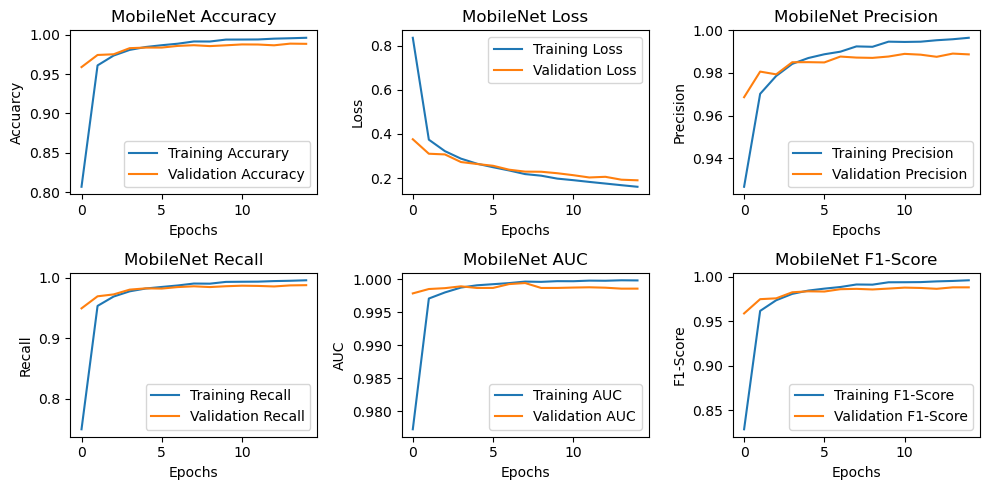

CPU times: user 2h 45min 9s, sys: 16min 29s, total: 3h 1min 38s
Wall time: 9min 17s


In [ ]:
%%time
base_mobilenet    = tf.keras.applications.MobileNet(include_top = False,
                                                    input_shape = (32, 32, 3),
                                                    weights     = None)

mobilenet_outputs = add_classifier(base_mobilenet)

mobilenet         = tf.keras.Model(inputs  = base_mobilenet.input,
                                   outputs = mobilenet_outputs,
                                   name    = "MobileNetV2_MNIST")

mobilenet_history = compile_and_train(mobilenet,
                                     train_dataset,
                                     val_dataset)


# save the model if the accuracy meet the threshold
train_acc_mobile  = mobilenet_history.history["accuracy"][-1]
val_acc_mobile    = mobilenet_history.history["val_accuracy"][-1]
_, test_acc_mobile, _, _, _, _   = mobilenet.evaluate(test_dataset)

if train_acc_mobile > 0.98 and val_acc_mobile > 0.98 and test_acc_mobile > 0.98:
    mobilenet.save("models/diff_extrcs/mobilenet_mnist.h5")
    print("Model saved as mobilenet_mnist.h5")

plot_performance(mobilenet_history, "MobileNet")

Epoch 1/15
938/938 [==============================] - 158s 156ms/step - loss: 0.5448 - accuracy: 0.9097 - precision: 0.9620 - recall: 0.8744 - auc: 0.9935 - f1_score: 0.9161 - val_loss: 0.3069 - val_accuracy: 0.9789 - val_precision: 0.9831 - val_recall: 0.9741 - val_auc: 0.9995 - val_f1_score: 0.9786
Epoch 2/15
938/938 [==============================] - 143s 152ms/step - loss: 0.3082 - accuracy: 0.9789 - precision: 0.9831 - recall: 0.9757 - auc: 0.9989 - f1_score: 0.9794 - val_loss: 0.2925 - val_accuracy: 0.9803 - val_precision: 0.9838 - val_recall: 0.9775 - val_auc: 0.9994 - val_f1_score: 0.9806
Epoch 3/15
938/938 [==============================] - 143s 152ms/step - loss: 0.2761 - accuracy: 0.9861 - precision: 0.9881 - recall: 0.9840 - auc: 0.9993 - f1_score: 0.9860 - val_loss: 0.2634 - val_accuracy: 0.9854 - val_precision: 0.9872 - val_recall: 0.9836 - val_auc: 0.9996 - val_f1_score: 0.9854
Epoch 4/15
938/938 [==============================] - 143s 152ms/step - loss: 0.2542 - accurac

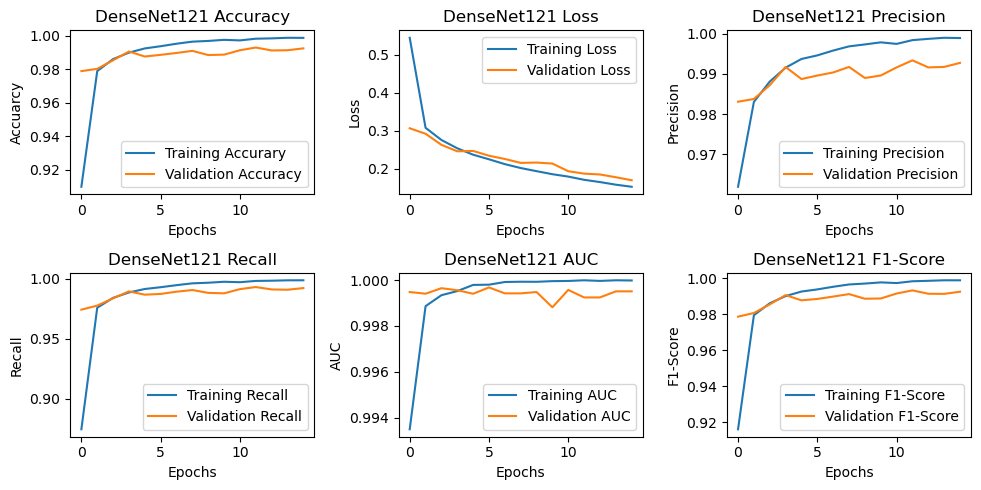

CPU times: user 9h 30min 53s, sys: 1h 18min 51s, total: 10h 49min 44s
Wall time: 36min 1s


In [ ]:
%%time
base_densenet     = tf.keras.applications.DenseNet121(weights     = None,
                                                      include_top = False,
                                                      input_shape = (32, 32, 3))

densenet_outputs  = add_classifier(base_densenet)

densenet          = tf.keras.Model(inputs = base_densenet.input,
                                  outputs = densenet_outputs,
                                  name    = "Densenet121-MNIST")

densenet_history  = compile_and_train(densenet,
                                     train_dataset,
                                     val_dataset)

train_acc_dense   = densenet_history.history["accuracy"][-1]
val_acc_dense     = densenet_history.history["val_accuracy"][-1]
_, test_acc_dense, _, _, _, _    = densenet.evaluate(test_dataset)

if train_acc_dense > 0.98 and val_acc_dense > 0.98 and test_acc_dense > 0.98:
    densenet.save("models/diff_extrcs/densenet_mnist.h5")
    print("Model saved as densenet_mnist.h5")

plot_performance(densenet_history, "DenseNet121")

In [ ]:
densenet.summary()

Epoch 1/15
938/938 [==============================] - 115s 110ms/step - loss: 1.3338 - accuracy: 0.6448 - precision: 0.8813 - recall: 0.5148 - auc: 0.9266 - f1_score: 0.6499 - val_loss: 0.4868 - val_accuracy: 0.9310 - val_precision: 0.9526 - val_recall: 0.9095 - val_auc: 0.9958 - val_f1_score: 0.9306
Epoch 2/15
938/938 [==============================] - 101s 108ms/step - loss: 0.5078 - accuracy: 0.9236 - precision: 0.9441 - recall: 0.9033 - auc: 0.9933 - f1_score: 0.9232 - val_loss: 0.3678 - val_accuracy: 0.9584 - val_precision: 0.9685 - val_recall: 0.9529 - val_auc: 0.9983 - val_f1_score: 0.9606
Epoch 3/15
938/938 [==============================] - 101s 108ms/step - loss: 0.4019 - accuracy: 0.9510 - precision: 0.9618 - recall: 0.9410 - auc: 0.9965 - f1_score: 0.9513 - val_loss: 0.3238 - val_accuracy: 0.9697 - val_precision: 0.9757 - val_recall: 0.9649 - val_auc: 0.9989 - val_f1_score: 0.9703
Epoch 4/15
938/938 [==============================] - 101s 108ms/step - loss: 0.3538 - accurac

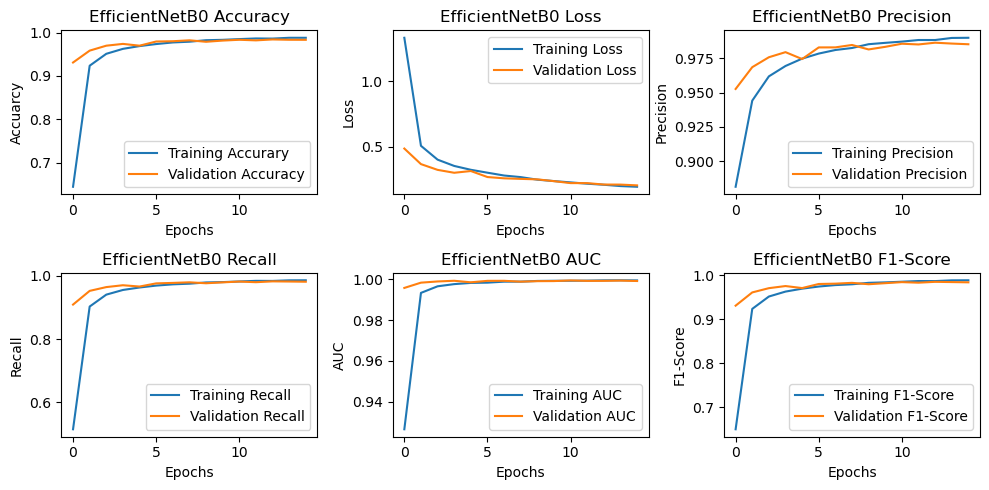

CPU times: user 5h 48min 56s, sys: 48min 53s, total: 6h 37min 50s
Wall time: 25min 33s


In [ ]:
%%time
base_effinet      = tf.keras.applications.EfficientNetB0(include_top = False,
                                                        input_shape  = (32,32,3),
                                                        weights      = None)

effinet_outputs   = add_classifier(base_effinet)

effinet           = tf.keras.Model(inputs  = base_effinet.input,
                                   outputs = effinet_outputs,
                                   name    = "EfficientNet-MNIST")

effinet_history   = compile_and_train(effinet,
                                  train_dataset,
                                  val_dataset)

train_acc_effinet = effinet_history.history["accuracy"][-1]
val_acc_effinet   = effinet_history.history["val_accuracy"][-1]
_, test_acc_effinet, _, _, _, _  = effinet.evaluate(test_dataset)

if train_acc_effinet > 0.98 and val_acc_effinet > 0.98 and test_acc_effinet > 0.98:
    effinet.save("models/diff_extrcs/effinet_mnist.h5")
    print("Model saved as effinet_mnist.h5")

plot_performance(effinet_history, "EfficientNetB0")

In [127]:
# ///////////////// With Different Optimizers /////////////////

In [15]:
def train_with_diff_optimizers(model, train_dataset, val_dataset, optimizer, epochs = 15):
    model.compile(
        optimizer = optimizer,
        loss      = "categorical_crossentropy",
        metrics   = [
            "accuracy",
            Precision(name = "precision"),
            Recall(name    = "recall"),
            AUC(name       = "auc"),
            F1Score(name   = "f1_score")
        ]
    )

    print(f"Training model with {type(optimizer).__name__} optimizer...")
    
    history = model.fit(train_dataset,
                       epochs          = epochs,
                       validation_data = val_dataset)
    
    return history

Training model with Adam optimizer...
Epoch 1/15
938/938 [==============================] - 9s 8ms/step - loss: 0.3438 - accuracy: 0.9333 - precision: 0.9628 - recall: 0.9101 - auc: 0.9961 - f1_score: 0.9357 - val_loss: 0.1705 - val_accuracy: 0.9771 - val_precision: 0.9811 - val_recall: 0.9721 - val_auc: 0.9993 - val_f1_score: 0.9766
Epoch 2/15
938/938 [==============================] - 8s 8ms/step - loss: 0.1374 - accuracy: 0.9813 - precision: 0.9848 - recall: 0.9779 - auc: 0.9993 - f1_score: 0.9813 - val_loss: 0.0936 - val_accuracy: 0.9895 - val_precision: 0.9911 - val_recall: 0.9886 - val_auc: 0.9996 - val_f1_score: 0.9899
Epoch 3/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0973 - accuracy: 0.9858 - precision: 0.9885 - recall: 0.9836 - auc: 0.9995 - f1_score: 0.9860 - val_loss: 0.0813 - val_accuracy: 0.9876 - val_precision: 0.9901 - val_recall: 0.9861 - val_auc: 0.9996 - val_f1_score: 0.9881
Epoch 4/15
938/938 [==============================] - 8s 8ms/step - 

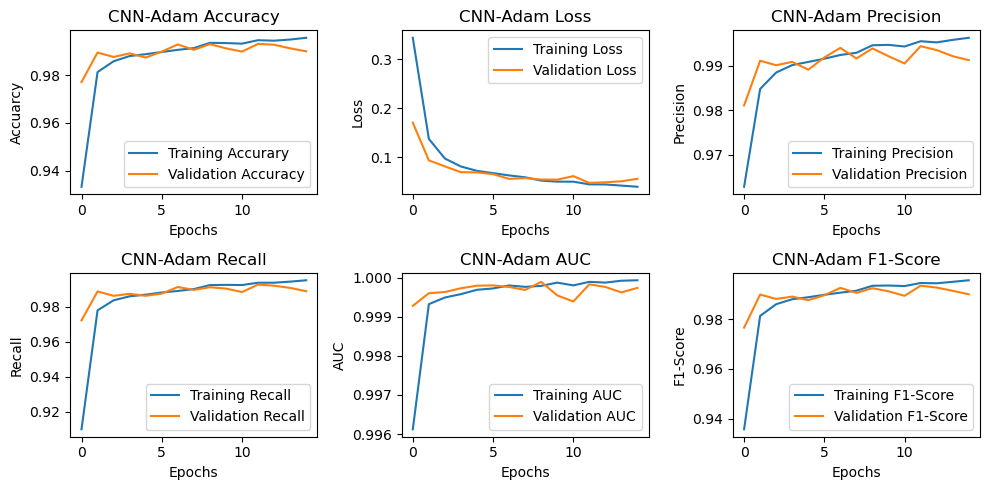

In [16]:
cnn_adam       = tf.keras.models.clone_model(base_cnn)
cnn_adam       = tf.keras.Model(inputs  = cnn_adam.input,
                                outputs = add_classifier(cnn_adam),
                                name    = "CNN-MNIST-Adam")

adam_history   = train_with_diff_optimizers(cnn_adam,
                                          train_dataset,
                                          val_dataset,
                                          optimizer = tf.keras.optimizers.Adam()
                                         )

train_acc_adam = adam_history.history["accuracy"][-1]
val_acc_adam   = adam_history.history["val_accuracy"][-1]
_, test_acc_adam, _, _, _, _  = cnn_adam.evaluate(test_dataset)

if train_acc_adam > 0.98 and val_acc_adam > 0.98 and test_acc_adam > 0.98:
    cnn_adam.save("models/diff_optimizers/cnn_mnist_adam.h5")
    print("Model saved as cnn_mnist_adam.h5")

plot_performance(adam_history, "CNN-Adam")

Training model with RMSprop optimizer...
Epoch 1/15
938/938 [==============================] - 9s 8ms/step - loss: 0.3016 - accuracy: 0.9423 - precision: 0.9641 - recall: 0.9247 - auc: 0.9966 - f1_score: 0.9440 - val_loss: 0.1538 - val_accuracy: 0.9764 - val_precision: 0.9795 - val_recall: 0.9745 - val_auc: 0.9983 - val_f1_score: 0.9770
Epoch 2/15
938/938 [==============================] - 8s 8ms/step - loss: 0.1181 - accuracy: 0.9813 - precision: 0.9848 - recall: 0.9783 - auc: 0.9992 - f1_score: 0.9815 - val_loss: 0.0831 - val_accuracy: 0.9865 - val_precision: 0.9878 - val_recall: 0.9854 - val_auc: 0.9995 - val_f1_score: 0.9866
Epoch 3/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0852 - accuracy: 0.9865 - precision: 0.9889 - recall: 0.9841 - auc: 0.9994 - f1_score: 0.9865 - val_loss: 0.0901 - val_accuracy: 0.9816 - val_precision: 0.9843 - val_recall: 0.9791 - val_auc: 0.9993 - val_f1_score: 0.9817
Epoch 4/15
938/938 [==============================] - 8s 8ms/step

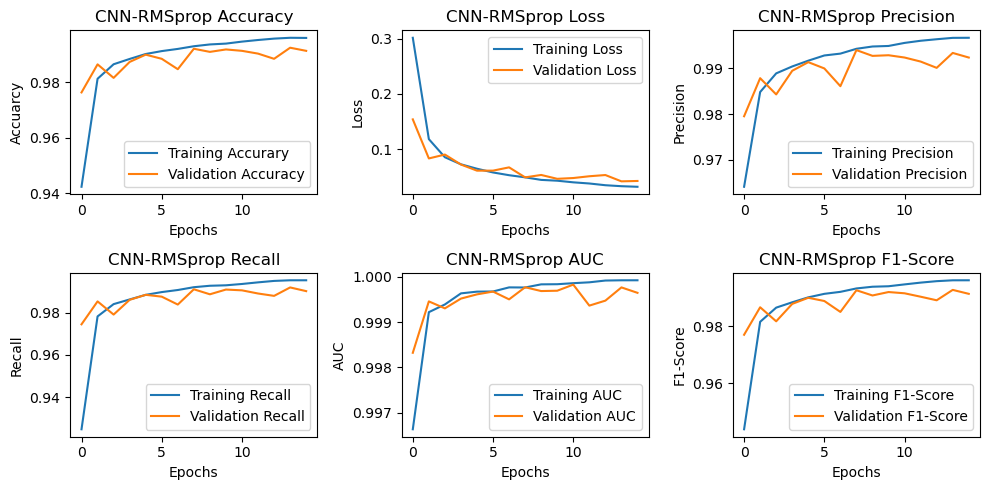

In [17]:
cnn_rmsp       = tf.keras.models.clone_model(base_cnn)
cnn_rmsp       = tf.keras.Model(inputs  = cnn_rmsp.input,
                               outputs  = add_classifier(cnn_rmsp),
                               name     = "CNN-MNIST-RMSprop")

rmsp_history   = train_with_diff_optimizers(cnn_rmsp,
                                           train_dataset,
                                           val_dataset,
                                           optimizer = tf.keras.optimizers.RMSprop()
                                           )

train_acc_rmsp = rmsp_history.history["accuracy"][-1]
val_acc_rmsp   = rmsp_history.history["val_accuracy"][-1]
_, test_acc_rmsp, _, _, _, _  = cnn_rmsp.evaluate(test_dataset)

if train_acc_rmsp > 0.98 and val_acc_rmsp > 0.98 and test_acc_rmsp > 0.98:
    cnn_rmsp.save("models/diff_optimizers/cnn_mnist_rmsp.h5")
    print("Model saved as cnn_mnist_rmsp.h5")

plot_performance(rmsp_history, "CNN-RMSprop")

Training model with Nadam optimizer...
Epoch 1/15
938/938 [==============================] - 10s 9ms/step - loss: 0.3405 - accuracy: 0.9336 - precision: 0.9643 - recall: 0.9112 - auc: 0.9962 - f1_score: 0.9370 - val_loss: 0.1845 - val_accuracy: 0.9719 - val_precision: 0.9772 - val_recall: 0.9688 - val_auc: 0.9983 - val_f1_score: 0.9729
Epoch 2/15
938/938 [==============================] - 8s 8ms/step - loss: 0.1408 - accuracy: 0.9805 - precision: 0.9845 - recall: 0.9770 - auc: 0.9991 - f1_score: 0.9807 - val_loss: 0.1022 - val_accuracy: 0.9864 - val_precision: 0.9888 - val_recall: 0.9840 - val_auc: 0.9994 - val_f1_score: 0.9864
Epoch 3/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0977 - accuracy: 0.9855 - precision: 0.9880 - recall: 0.9827 - auc: 0.9995 - f1_score: 0.9854 - val_loss: 0.0724 - val_accuracy: 0.9896 - val_precision: 0.9921 - val_recall: 0.9874 - val_auc: 0.9999 - val_f1_score: 0.9897
Epoch 4/15
938/938 [==============================] - 8s 8ms/step 

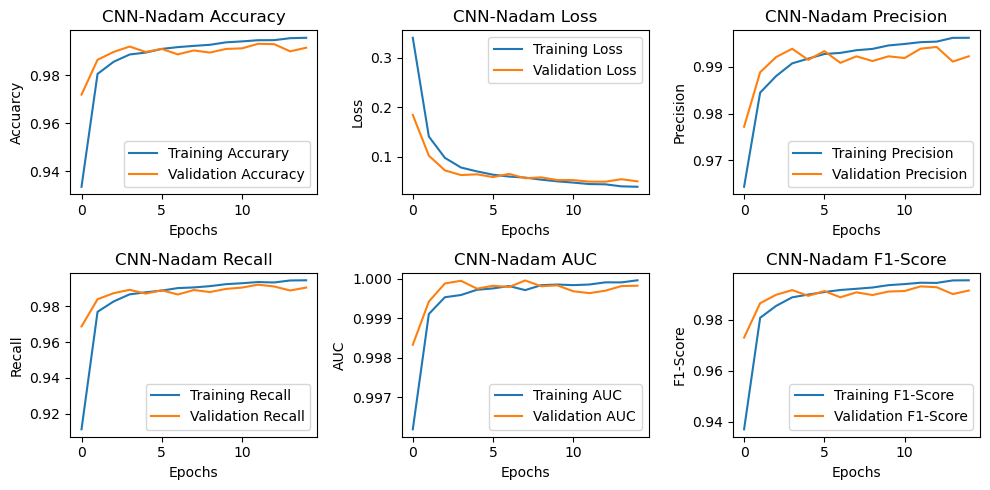

In [18]:
cnn_nadam       = tf.keras.models.clone_model(base_cnn)
cnn_nadam       = tf.keras.Model(inputs  = cnn_nadam.input,
                                 outputs = add_classifier(cnn_nadam),
                                 name    = "CNN-MNIST-Nadam")

nadam_history   = train_with_diff_optimizers(cnn_nadam,
                                           train_dataset,
                                           val_dataset,
                                           optimizer = tf.keras.optimizers.Nadam()
                                           )

train_acc_nadam = nadam_history.history["accuracy"][-1]
val_acc_nadam   = nadam_history.history["val_accuracy"][-1]
_, test_acc_nadam, _, _, _, _  = cnn_nadam.evaluate(test_dataset)

if train_acc_nadam > 0.98 and val_acc_nadam > 0.98 and test_acc_nadam > 0.98:
    cnn_nadam.save("models/diff_optimizers/cnn_mnist_nadam.h5")
    print("Model saved as cnn_mnist_nadam.h5")

plot_performance(nadam_history, "CNN-Nadam")